<a href="https://colab.research.google.com/github/antahiap/dsr-nlp/blob/main/notebooks/02_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Datasets

In [6]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers


In [7]:
datasets, info = tfds.load(    # unonomus variable
            "imdb_reviews/plain_text",
            split=["train", "test[:50%]",  "test[50%:]"],
            as_supervised=True, # not activeated, the data will be as dict, now as tuple
            with_info =True    #
)

dataset_train_original = datasets[0]
dataset_validate_original =  datasets[1]
dataset_test_original = datasets[2]
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXLH926/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXLH926/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXLH926/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path=PosixGPath('/tmp/tmp84agto9mtfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInf

In [8]:
# Look at your beeping data

In [9]:
for review, label in dataset_train_original.take(16):
  print(review.numpy().decode('utf-8'))
  print(label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was co

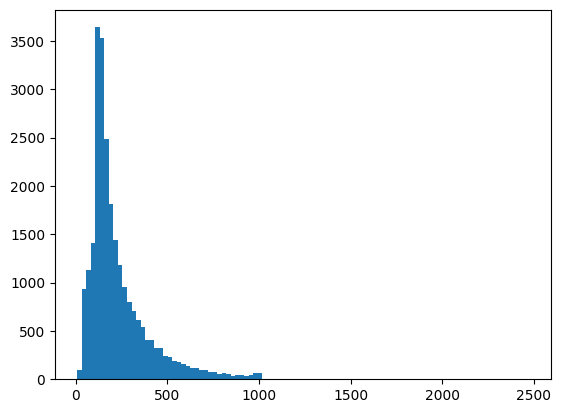

In [10]:
lengths = []
for x, _ in dataset_train_original:
  x = x.numpy().decode('utf-8')
  lengths += [len(x.split())]

plt.hist(lengths, bins=100)
plt.show()

In [11]:
print("Min", np.min(lengths))
print("Mean", np.mean(lengths))
print("STD", np.std(lengths))
print("Max", np.max(lengths))

Min 10
Mean 233.7872
STD 173.72955740506566
Max 2470


# Data Balance Investigation

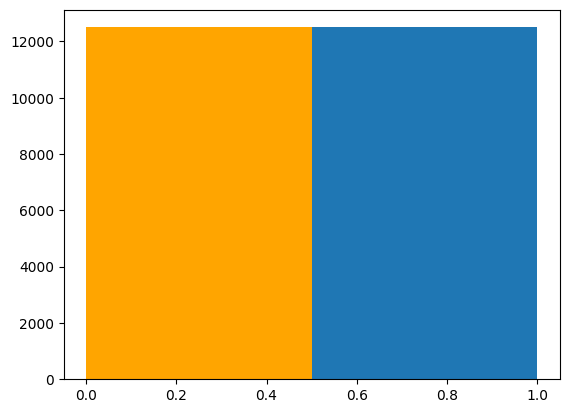

In [12]:
labels = []
for _, label in dataset_train_original:
  label = label.numpy()
  labels += [label]
  # assert False, f'{label}'

_, _, patches = plt.hist(labels, bins=2)
patches[0].set_facecolor('orange')
plt.show()

## Encoding
### Bag of Words Encoding
- Sparse matrix, mostly zeros
- losing order

In [13]:
vocabulary_size = 10_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='multi_hot'
)
encoder.adapt(dataset_train_original.map(lambda text, label:text).batch(2048))

In [14]:
vocabulary = encoder.get_vocabulary()
print(vocabulary[:40])

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like', 'her']


- [UNK]: The word that is not in the dic as the length of it is limited.

In [15]:
text = "Make AI open again."
text_encoded = encoder(text).numpy()
text_encoded = [str(int(x)) for x in text_encoded]
text_encoded = ''.join(text_encoded)
print(text_encoded)

1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000

# Datasets Pipline

In [16]:
dataset_train = dataset_train_original.cache().shuffle(25_000).batch(128)

dataset_validate = dataset_validate_original.cache().batch(128)

dataset_test = dataset_test_original.cache().batch(128)

# ANN

In [17]:
pip install wandb

In [18]:
import wandb
from wandb.keras import WandbMetricsLogger

# Initialize a new W&B run
wandb.init(config={"bs": 128})

In [19]:
model = models.Sequential()
model.add(encoder)
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation='sigmoid'))   # another option: layers.Dense(2, activation='softmax')
model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_validate,
    callbacks=[WandbMetricsLogger()]
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 10000)            0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 640,129
Trainable params: 640,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 18s 47ms/step - loss: 0.3363 - accuracy: 0.8622 - val_loss: 0.2895 - val_accuracy: 0.8816
Epoch 2/10
196/196 [==============================] - 5s 25ms/step - loss: 0.1893 - accuracy: 0.9284 - v

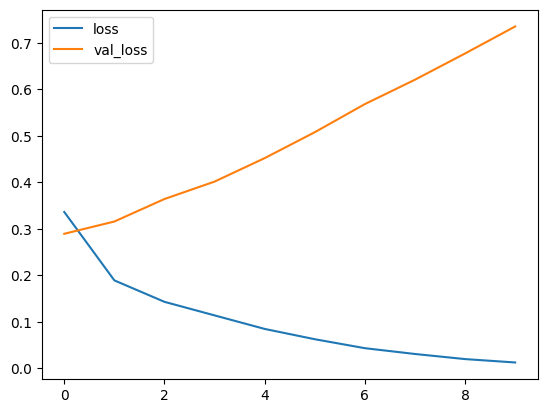

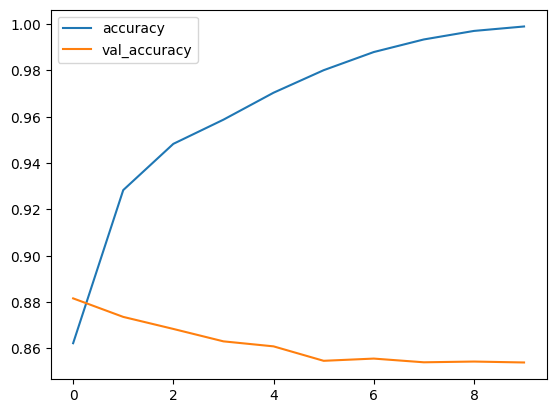

In [20]:
def render_history(history):
  assert isinstance(history, dict), f"Expected dict, but got {type(history)}"

  plt.plot(history['loss'], label='loss')
  plt.plot(history['val_loss'], label="val_loss")
  plt.legend()
  plt.show()

  plt.plot(history['accuracy'], label="accuracy")
  plt.plot(history['val_accuracy'], label="val_accuracy")
  plt.legend()

render_history(history.history)

In [21]:
text = 'This is a text that embassy has time available to book for mom.'
model.predict([text])

1/1 [==============================] - 0s 168ms/step


array([[0.8595747]], dtype=float32)